# Postprocessing of PMDI X-ray Phase Contrast Images

This program takes X-ray phase contrast images of PMDI sprays and uses Fourier analysis to estimate droplet properties.
    
    @author Daniel Duke <daniel.duke@monash.edu>
    @copyright (c) 2020 LTRAC
    @license GPL-3.0+
    @version 0.0.1
    @date 19/05/2021
        __   ____________    ___    ______
       / /  /_  ____ __  \  /   |  / ____/
      / /    / /   / /_/ / / /| | / /
     / /___ / /   / _, _/ / ___ |/ /_________
    /_____//_/   /_/ |__\/_/  |_|\__________/

    Laboratory for Turbulence Research in Aerospace & Combustion (LTRAC)
    Monash University, Australia



In [1]:
from pySciCam.pySciCam import ImageSequence # https://github.com/djorlando24/pySciCam
import numpy as np
import glob, sys, os
import matplotlib.pyplot as plt
from scipy.interpolate import interp2d
import scipy.integrate, scipy.signal
from joblib import Parallel, delayed
%matplotlib notebook


In [17]:
# Define where images come from.
root_dir = "/mnt/squash/"
source_images = root_dir + "MonashMedicalSpray_NewMirror/H134_15_B_NO_5_C001H001S0001"

# Frame rate and resolution
frame_rate = 271557.
um_per_pixel = 0.4424
bkgnd_frames=(1,20)

## Load images
Crop and mask as required. Remove background.

In [3]:
I=ImageSequence(source_images, IO_threads=4)

Reading /mnt/squash/MonashMedicalSpray_NewMirror/H134_15_B_NO_5_C001H001S0001
	Found 30000 images with extension .tif
	PythonMagick thinks the bit depth is uint12
	Increasing stored bit depth from <class 'numpy.uint16'> to <class 'numpy.uint32'>
	Reading files into memory...
40 tasks on 4 processors


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   10.0s
[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:   29.5s finished


Read 1582.0 MiB in 30.9 sec
	Data in memory:	 (30000, 144, 256)
	Intensity range:	 0 to 37945 	 uint32
	Array size:	4218.8 MB


<IPython.core.display.Javascript object>


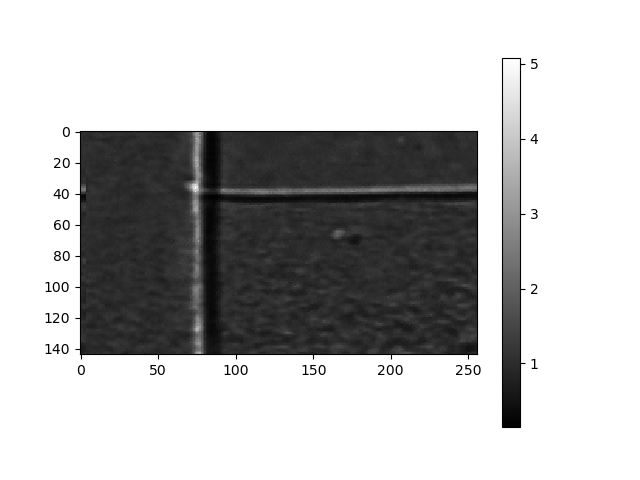

In [4]:
# Remove background, put into array Ib
Ib = np.zeros_like(I.arr,dtype=np.float32)
bkgnd = np.nanmean(I.arr[bkgnd_frames[0]:bkgnd_frames[1]+1,...],axis=0).astype(np.float32)
bkgnd[bkgnd<=0] = np.nan
for n in range(I.N):
    Ib[n,...] = I.arr[n,...] / bkgnd

plt.figure()
h=plt.imshow(Ib[9000,...],cmap=plt.cm.gray)
plt.colorbar(h);

Frame range for analysis: 3288 - 25212


<IPython.core.display.Javascript object>


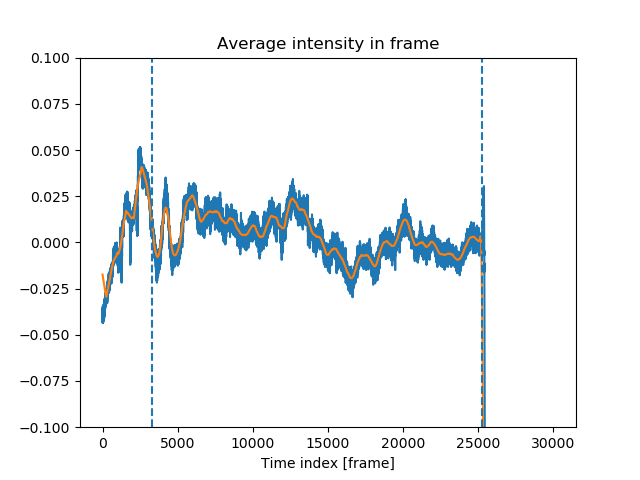

Text(0.5, 0, 'Time index [frame]')

In [5]:
# Find valid region in time for analysis
avg_intensity = np.nanmean(np.nanmean(Ib,axis=-1),axis=-1)
avg_intensity -=  np.median(avg_intensity)

# Rolling average (smooth)
ww=500
rolling_avg_intensity = np.convolve(avg_intensity, np.ones(ww,), 'same')/float(ww)

# Find first peak
t00=np.where(rolling_avg_intensity[:10*ww] == np.nanmax(rolling_avg_intensity[:10*ww]))[0][0]
# Find steady region after first peak
t0=np.where(np.abs(rolling_avg_intensity[t00:])<0.01)[0][0] + t00
# Find end of steady region
t1=np.where(rolling_avg_intensity>-0.01)[0][-1]
print("Frame range for analysis: %i - %i" % (t0,t1))

# Get co-ordinates
y = np.arange(Ib.shape[1])
x = np.arange(Ib.shape[2])
t = np.arange(Ib.shape[0])

plt.figure()
plt.plot(t,avg_intensity)
plt.plot(t,rolling_avg_intensity)
plt.ylim(-.1,.1)
plt.axvline(t0,ls='--')
plt.axvline(t1,ls='--')
plt.title("Average intensity in frame")
plt.xlabel("Time index [frame]")

In [54]:
# Spatial fourier analysis of ROI
roi = (107,256,59,144)
x_roi = x[roi[0]:roi[1]]
y_roi = y[roi[2]:roi[3]]

Is = Ib[t0:t1,roi[2]:roi[3],roi[0]:roi[1]]

def proc_one_frame(fr, axis=1):
    f = np.abs(  np.fft.rfft2(fr)   )
    #f = np.abs(  np.fft.rfft2(np.pad(fr,int(len(fr)/2),'constant'))   )
    f[:1] = np.nan
    f[-2:] = np.nan
    return np.nanmean(np.fft.fftshift(f), axis=axis)

ffts = Parallel(n_jobs=-1,verbose=5)(delayed(proc_one_frame)(Is[i,...]) for i in range(Is.shape[0]))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 279 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 4096 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 14464 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 21618 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 21924 out of 21924 | elapsed:    6.1s finished


<ipython-input-57-a28034c70224>:1: RuntimeWarning: Mean of empty slice
  avg_spectrum = np.nanmean(np.vstack(ffts),axis=0)


<IPython.core.display.Javascript object>


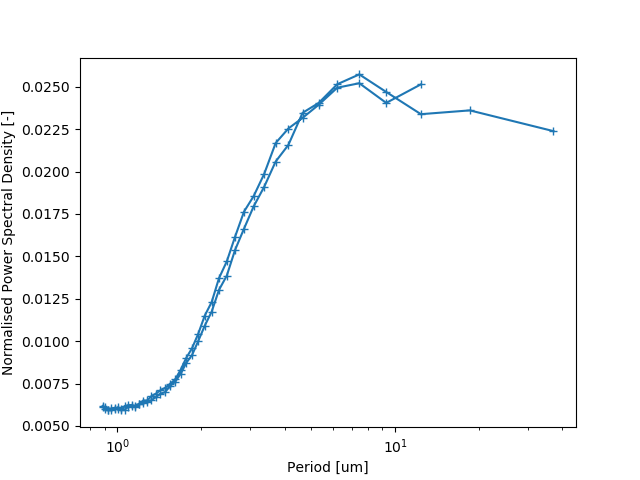

<ipython-input-57-a28034c70224>:8: RuntimeWarning: divide by zero encountered in true_divide
  pd=np.abs(um_per_pixel/k) # period [um]


In [57]:
avg_spectrum = np.nanmean(np.vstack(ffts),axis=0)
k=np.linspace(-.5,.5,len(avg_spectrum)) # wavenumber [px^-1]

avg_spectrum /= scipy.integrate.simps(np.nan_to_num(avg_spectrum))
#avg_spectrum *= np.var(np.nan_to_num(Is))
plt.figure()

pd=np.abs(um_per_pixel/k) # period [um]
plt.semilogx(pd, avg_spectrum, marker='+')
plt.xlabel("Period [um]")
plt.ylabel("Normalised Power Spectral Density [-]");
